# 1. loading data
## installing packages 

In [79]:
%pip install seaborn numpy pandas xgboost -qqU

# Importing libs

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor
import xgboost
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
import calendar
from sklearn.preprocessing import OneHotEncoder
import pickle

# reading data and discarding data of years after 2019

In [122]:
data = pd.read_csv('data.csv')

In [123]:
data = data[~(data['JAHR'] > 2019)]
data = data[data.columns[:5]]

In [124]:
data.reset_index(drop=True, inplace=True)

## here I removed the outliers outside z-threshold because these values often dont provide any useful information or help converge the model

In [125]:
def remove_outliers(df, columns=None, z_threshold=3):

    if columns is None:
        columns = df.select_dtypes(include=[np.number]).columns


    df_clean = df.copy()


    for col in columns:
        z_scores = np.abs((df_clean[col] - df_clean[col].mean()) / df_clean[col].std())
        df_clean = df_clean[z_scores < z_threshold]

    return df_clean


data = remove_outliers(data)


In [ ]:
# checked for null values
data.isna().sum()

,0
MONATSZAHL,0
AUSPRAEGUNG,0
JAHR,0
MONAT,0
WERT,0


# 2 . visualizing the data as per the assignment

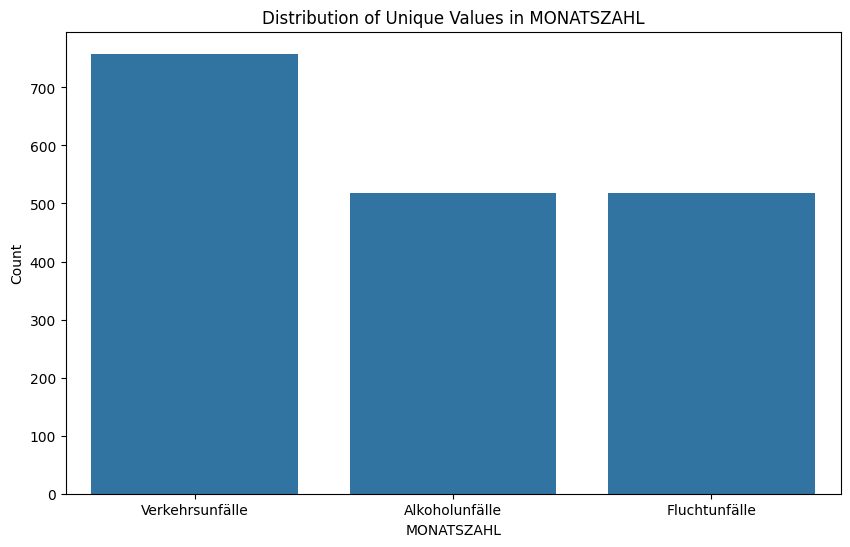

In [127]:
value_counts = data['MONATSZAHL'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=value_counts.index, y=value_counts.values)
plt.xlabel('MONATSZAHL')
plt.ylabel('Count')
plt.title('Distribution of Unique Values in MONATSZAHL')
plt.show()


## i saw some redundant information here so i converted the months to only have the months because the year would already provide relevant insight

In [128]:
def convert_to_month_name(year_month):

    if year_month == 'Summe':
        return 'Summe'
    month = str(year_month)[4:6]


    month_name = calendar.month_name[int(month)]
    return month_name
data['MONAT'] = data['MONAT'].apply(convert_to_month_name)

In [129]:
data['MONAT'].value_counts()

,count
MONAT,
January,140
March,140
February,140
April,140
May,140
September,140
June,140
July,140
August,140


In [130]:
data['JAHR'].value_counts()

,count
JAHR,
2019,90
2018,90
2017,90
2016,90
2015,90
2014,90
2013,90
2012,90
2011,90


### after checking for data imbalances , now we can train the model, we first one hot all the categorical columns, another good approach according to me would be to just use cardinal encoding but my results didnt seem excessively differing so i went with one hot

In [134]:
one_hot_columns = data.columns[0:4]

In [136]:

def one_hot_encode(data, one_hot_columns):

    data_copy = data.copy()


    encoder = OneHotEncoder(sparse_output=False)


    encoded_columns = encoder.fit_transform(data_copy[one_hot_columns])


    encoded_column_names = encoder.get_feature_names_out(one_hot_columns)


    encoded_df = pd.DataFrame(
        encoded_columns,
        columns=encoded_column_names,
        index=data_copy.index
    )


    result_df = pd.concat([
        data_copy.drop(columns=one_hot_columns),
        encoded_df
    ], axis=1)

    return result_df, encoder

def transform_new_data(new_data, encoder, original_one_hot_columns):

    new_data_copy = new_data.copy()


    encoded_columns = encoder.transform(new_data_copy[original_one_hot_columns])


    encoded_column_names = encoder.get_feature_names_out(original_one_hot_columns)


    encoded_df = pd.DataFrame(
        encoded_columns,
        columns=encoded_column_names,
        index=new_data_copy.index
    )


    result_df = pd.concat([
        new_data_copy.drop(columns=original_one_hot_columns),
        encoded_df
    ], axis=1)

    return result_df

In [139]:
data, encoder = one_hot_encode(data, one_hot_columns)

In [93]:
print(xgboost.build_info())

{'BUILTIN_PREFETCH_PRESENT': True, 'CUDA_VERSION': [11, 8], 'DEBUG': False, 'GCC_VERSION': [10, 3, 1], 'MM_PREFETCH_PRESENT': True, 'NCCL_VERSION': [2, 16, 5], 'THRUST_VERSION': [1, 15, 1], 'USE_CUDA': True, 'USE_DLOPEN_NCCL': True, 'USE_FEDERATED': True, 'USE_NCCL': True, 'USE_OPENMP': True, 'USE_RMM': False, 'libxgboost': '/usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so'}


# 3. finally training the model and downloading it as pkl to use in api

In [142]:
X = data.drop(columns=['WERT'])
y = data['WERT']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


xgb = XGBRegressor(
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    verbosity=2
)


param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}


grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)


best_params = grid_search.best_params_
print("Best parameters found: ", best_params)


results = pd.DataFrame(grid_search.cv_results_)


results['mean_test_score'] = -results['mean_test_score']


print(results[['param_n_estimators', 'param_learning_rate', 'param_max_depth', 'param_subsample', 'param_colsample_bytree', 'mean_test_score']])


best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error on the test set: ", mse)


Fitting 3 folds for each of 243 candidates, totalling 729 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:01:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:01:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters found:  {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.7}
     param_n_estimators  param_learning_rate  param_max_depth  \
0                   100                 0.01                3   
1                   100                 0.01                3   
2                   100                 0.01                3   
3                   200                 0.01                3   
4                   200                 0.01                3   
..                  ...                  ...              ...   
238                 200                 0.20                7   
239                 200                 0.20                7   
240                 300                 0.20                7   
241                 300                 0.20                7   
242                 300                 0.20                7   

     param_subsample  param_colsample_bytree  mean_test_score  
0                0.7        

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:01:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


In [165]:
ex = pd.DataFrame({
    'MONATSZAHL': ['Alkoholunfälle'],
    'AUSPRAEGUNG': ['Verletzte und Getötete'],
    'JAHR': [2012],
    'MONAT': ['201207']
})
ex['MONAT'] = ex['MONAT'].apply(convert_to_month_name)
new = transform_new_data(ex, encoder, one_hot_columns)


In [ ]:
with open('xgb.pkl', 'wb') as file:
    pickle.dump(best_model, file)
